# Analysing results

In [1]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt

from IPython.display import clear_output

from scipy.stats import levene

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

## Analysing mean absolute errors

In [2]:
error_results = {'Gradient Boosting Regressor' : {'1.0' : [], '0.75' : [], '0.5' : []}, \
                  'Random Forest Regressor' : {'1.0' : [], '0.75' : [], '0.5' : []}, \
                    'Zero-Inflated Beta Regressor' : {'1.0' : [], '0.75' : [], '0.5' : []}
                    }

In [3]:
model_names = list(error_results.keys())
sample_sizes = list(error_results[model_names[0]].keys())
labels = ['gb', 'rf', 'br']

seeds = [i for i in range(50)]

In [4]:
for index, label in enumerate(labels):
    for size in sample_sizes:
        size_label = ''.join(size.split('.'))

        for seed in seeds:
            result_array = np.loadtxt(f'./Results/{label}_{size_label}_{seed}_errors.csv', delimiter=',', dtype=float)

            # The mean of the ABSOLUTE errors is calculated.
            mean = np.mean(np.abs(result_array))

            error_results[model_names[index]][size].append(mean)

In [5]:
mean_errors = np.zeros((len(model_names), len(sample_sizes)))
std_errors = np.zeros((len(model_names), len(sample_sizes)))

for i, model in enumerate(model_names):
    for j, size in enumerate(sample_sizes):
        errors = error_results[model][size]
        
        mean_errors[i, j] = np.mean(errors)
        std_errors[i, j] = np.std(errors)

In [6]:
print('Mean absolute errors:')

for i, model in enumerate(model_names):
    print(model + ':', mean_errors[i])

print('\nStandard deviations:')

for i, model in enumerate(model_names):
    print(model + ':', std_errors[i])

Mean absolute errors:
Gradient Boosting Regressor: [0.00237373 0.00176756 0.0017739 ]
Random Forest Regressor: [0.00296474 0.00234868 0.00261281]
Zero-Inflated Beta Regressor: [0.00475779 0.00369028 0.00470562]

Standard deviations:
Gradient Boosting Regressor: [0.         0.00027733 0.00030053]
Random Forest Regressor: [0.         0.00025037 0.00038579]
Zero-Inflated Beta Regressor: [0.         0.00041604 0.00061997]


In [7]:
colors = ['midnightblue', 'cornflowerblue', 'skyblue']

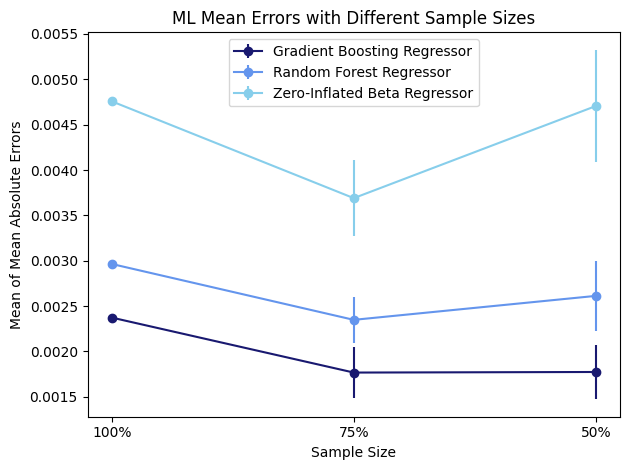

In [8]:
fig, ax = plt.subplots()

x_pos = np.arange(len(sample_sizes))
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{float(i) * 100:.0f}%' for i in sample_sizes])

ax.set_xlabel('Sample Size')
ax.set_ylabel('Mean of Mean Absolute Errors')

ax.set_title('ML Mean Errors with Different Sample Sizes')

for i, model in enumerate(model_names):
    ax.errorbar(x_pos, mean_errors[i], yerr=std_errors[i], fmt="o-", label=model, color=colors[i])

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/mean_errors.png')

plt.show()

### Performing an ANOVA test to test the effect of model choice, sample size or their interaction

Based on the visualization of errors above, this test is only conducted for the Random Forest and Gradient Boosting regressor, and only for the reduced sample sizes. The reasoning behind this:
* The Zero-Inflated Beta Regressor clearly had much larger errors across all sample sizes.
* The performance of the other two models on the complete dataset is very similar, and since this dataset cannot have any variation, it is not meaningful to conduct a statistical test in this case.

#### Performing Levene's test for equal variances

In [9]:
data = []

for model in model_names:
    for size in sample_sizes[1:]:
        data.append(error_results[model][size])

statistic, p_value = levene(*data)

print("Levene's Test Results:")
print(f" - Test Statistic: {statistic:.4f}")
print(f" - p-value: {p_value:.4f}")

Levene's Test Results:
 - Test Statistic: 12.8044
 - p-value: 0.0000


In [10]:
results_df = pd.DataFrame(columns=['Model', 'SampleSize', 'MeanError'])

for model, results in list(error_results.items()):
    for sample_size, mean_errors in list(results.items()):
        for mean_error in mean_errors:
            results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_index=True)

formula = 'MeanError ~ Model + SampleSize + Model:SampleSize'
model = ols(formula, results_df).fit()
anova_table = anova_lm(model)

# Print the ANOVA table
print("Two-way ANOVA Test Results:")
print(anova_table)

/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_13373/234897935.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_index=True)
/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_13373/234897935.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_index=True)
/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_13373/234897935.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_inde

Two-way ANOVA Test Results:
                     df    sum_sq       mean_sq            F         PR(>F)
Model               2.0  0.000465  2.326847e-04  2192.130084  7.627584e-230
SampleSize          2.0  0.000044  2.195562e-05   206.844572   4.315226e-64
Model:SampleSize    4.0  0.000014  3.495539e-06    32.931586   4.841440e-24
Residual          441.0  0.000047  1.061455e-07          NaN            NaN


/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_13373/234897935.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_index=True)
/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_13373/234897935.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_index=True)
/var/folders/t3/fn5x2gps4wq728lxf9qrv_lm0000gn/T/ipykernel_13373/234897935.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model, 'SampleSize': sample_size, 'MeanError': mean_error}, ignore_inde

## Analysing ability to predict large ratios

In [11]:
thresholds = [0.25, 0.5, 0.75]

y_tests = {'1.0' : [], '0.75' : [], '0.5' : []}

y_tests_aboveTH = {'1.0' : {}, '0.75' : {}, '0.5': {}}

for size in sample_sizes:
    for th in thresholds:
        y_tests_aboveTH[size][th] = []

In [12]:
for size in sample_sizes:
    size_label = size_label = ''.join(size.split('.'))

    for seed in seeds:
        y_test = np.loadtxt(f'./Data for testing/{size_label}_{seed}_ytest.csv', delimiter=',', dtype=float)

        y_tests[size].append(y_test)

        nr_values = y_test.shape[0] * y_test.shape[1]

        for th in thresholds:
            y_tests_aboveTH[size][th].append(np.sum(y_test > th) / nr_values * 100)

In [13]:
corrects_aboveTH = {'Gradient Boosting Regressor' : {'1.0' : {}, '0.75' : {}, '0.5' : {}}, \
                    'Random Forest Regressor' : {'1.0' : {}, '0.75' : {}, '0.5' : {}}, \
                        'Zero-Inflated Beta Regressor' : {'1.0' : {}, '0.75' : {}, '0.5' : {}}
                            }

for model in model_names:
    for size in sample_sizes:
        for th in thresholds:
            corrects_aboveTH[model][size][th] = []

In [14]:
for index, label in enumerate(labels):
    for size in sample_sizes:
        size_label = ''.join(size.split('.'))

        for seed in seeds:
            y_pred = np.loadtxt(f'./Results/{label}_{size_label}_{seed}_y_pred.csv', delimiter=',', dtype=float)

            y_test = y_tests[size][seed]

            nr_values = np.shape(y_test)[0] * np.shape(y_test)[1]

            for th in thresholds:
                correct_aboveTH = np.count_nonzero(np.logical_and(y_test > th, y_pred > th)) / nr_values * 100

                corrects_aboveTH[model_names[index]][size][th].append(correct_aboveTH)

In [15]:
means_aboveTH = {}
stds_aboveTH = {}

for size in sample_sizes:
    mean_aboveTH = np.zeros((len(model_names)+1, len(thresholds)))
    std_aboveTH = np.zeros((len(model_names)+1, len(thresholds)))
    
    for j, th in enumerate(thresholds):
        true_aboveTH = y_tests_aboveTH[size][th]

        mean_aboveTH[0, j] = np.mean(true_aboveTH)
        std_aboveTH[0, j] = np.std(true_aboveTH)
            
        for i, model in enumerate(model_names):
            aboveTH = corrects_aboveTH[model][size][th]
            
            mean_aboveTH[i+1, j] = np.mean(aboveTH)
            std_aboveTH[i+1, j] = np.std(aboveTH)

    means_aboveTH[size] = mean_aboveTH
    stds_aboveTH[size] = std_aboveTH

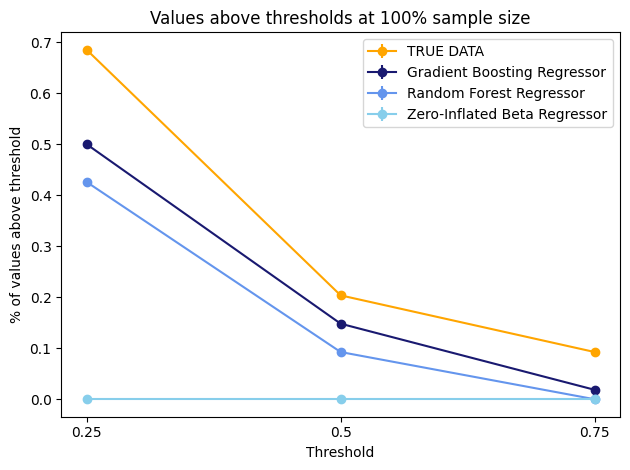

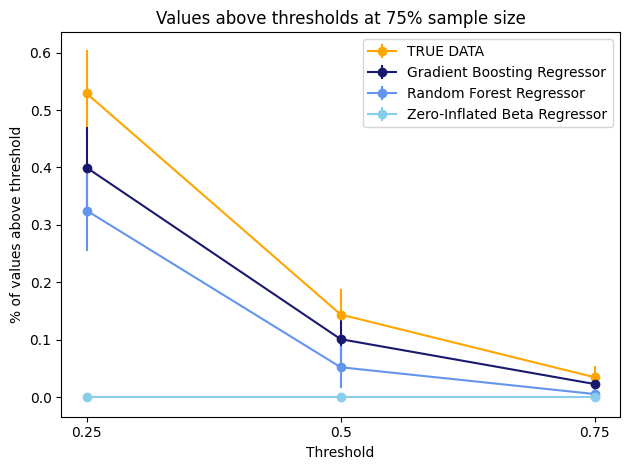

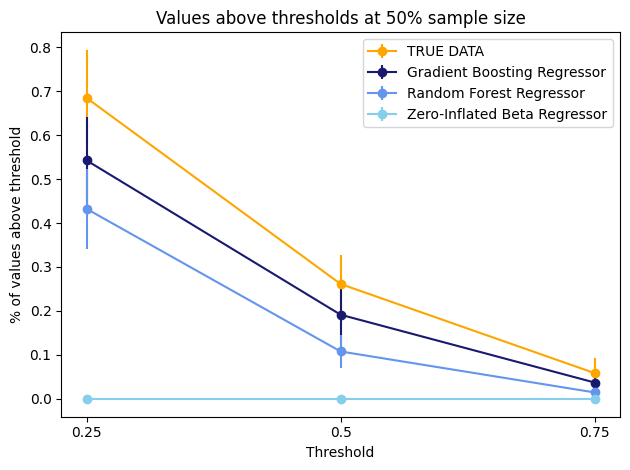

In [16]:
for size in sample_sizes:

    fig, ax = plt.subplots()

    x_pos = np.arange(len(thresholds))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(thresholds)

    ax.set_title(f'Values above thresholds at {float(size) * 100:.0f}% sample size')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('% of values above threshold')

    ax.errorbar(x_pos, means_aboveTH[size][0], yerr=stds_aboveTH[size][0], fmt="o-", label='TRUE DATA', color='orange')

    for i, model in enumerate(model_names):
        ax.errorbar(x_pos, means_aboveTH[size][i+1], yerr=stds_aboveTH[size][i+1], fmt="o-", label=model, color=colors[i])

    ax.legend()

    plt.tight_layout()

    size_label = ''.join(size.split('.'))

    plt.savefig(f'./Figures/values_above_threshold_{size_label}_size')

    plt.show()